# KSA: Polar Observations and Modelling

# Week 7 - A model experiment to study future changes

Now that we have contextualised the simulations we will be working on and looked at the forcing fields used to create them in `1_Future_changes_model_experiments.ipynb`, let's actually go and look at what changes happen in the Southern Ocean. We will look at the simulation with no changes to meltwater, i.e. a future projection in which there is no increase discharge from melting ice sheets.

Like we saw in our future projections forcing fields, we are going to be looking at an ocean simulation forced with:

1. Stronger westerlies further south
2. Weaker Antarctic coastal easterlies
3. Increased surface temperature driven by increased incoming radiation
4. Increased precipitation (liquid + solid)

Now we can start to look at how the ocean has responded to the changes in the forcing fields. We will start by looking only at the simulation *without* meltwater (orange line), and we will compare the last year of the perturbation and control simulations: 

<div align="center",style="max-width: 500px;">
    <img src="images/sim_schematic_1.png" width="60%" />
</div>

#### Question 1

Discuss, given the changes to the forcing fields, what would you expect to see happen to the ocean's circulation, stratification, temperature/salinity structure, etc. Don't be afraid to speculate.

*Answer here*

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cft
import cmocean as cm
import glob
import gsw
import matplotlib.lines as mlines
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import metpy
import numpy as np
import xarray as xr
import xarrayMannKendall as xrmk

In [2]:
def stereographic_axis(ax):
    
    ax.set_extent([-180, 180, -80, -50], crs = ccrs.PlateCarree())
    ax.add_feature(cft.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='gainsboro',
                                            facecolor='gainsboro'))
    ax.coastlines(resolution = "110m")
    # Map the plot boundaries to a circle
    theta = np.linspace(0, 2 * np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)

    return ax

## Load data

Let's load output from the control and the perturbation experiment data using `xr.open_mfdataset` again.

In [3]:
path_ctrl = glob.glob('/home/561/jn8053/g_jk72/KSA_Observations_Modelling/Class7/data/control*.nc') 
control = xr.open_mfdataset(path_ctrl, chunks = 'auto')

In [4]:
path_pert = glob.glob('/home/561/jn8053/g_jk72/KSA_Observations_Modelling/Class7/data/ssp585*.nc') 
exp_585 = xr.open_mfdataset(path_pert, chunks = 'auto')

#### Question 2 

What variables do we have available?

*Answer here*

## Changes to temperature and salinity

Let's look at changes in surface and bottom temperature and salinities. SST and SSS in the Southern Ocean can be influenced by a number of factors, one of which is the presence of sea ice. Sea ice acts as an insulator, shielding the surface ocean from intense heat exchange with the atmosphere, and imparts a significant flux of freshwater with its formation and melt cycle. 

Let's calculate the anomalies of the perturbation experiment with respect to control:

In [8]:
temp_anom = exp_585['temp'] - control['temp']
salt_anom = exp_585['salt'] - control['salt']

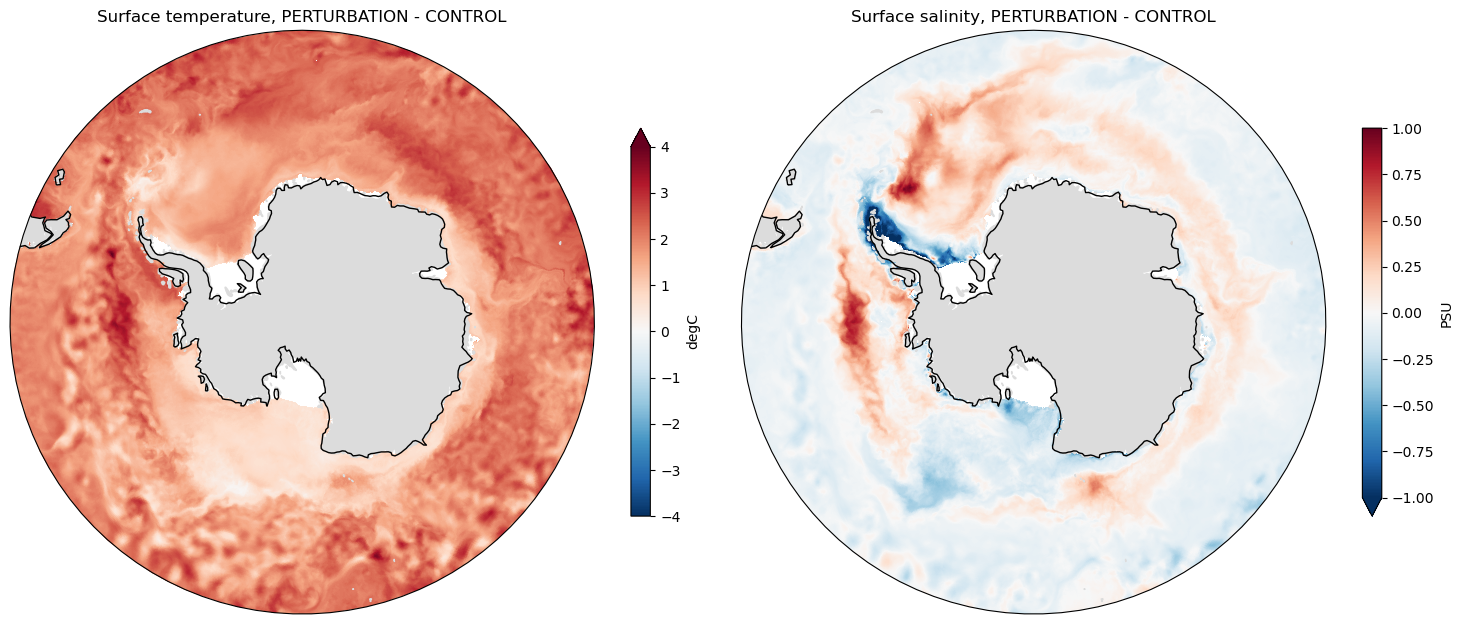

In [9]:
fig = plt.figure(figsize = (15, 10))
axs = [fig.add_subplot(121, projection = ccrs.SouthPolarStereo()),
       fig.add_subplot(122, projection = ccrs.SouthPolarStereo())]
for ax in axs:
    ax = stereographic_axis(ax)

temp_anom.sel(st_ocean = 0, method = 'nearest').plot(ax = axs[0], cmap = 'RdBu_r', vmin = -4, vmax = 4,
                                                     transform = ccrs.PlateCarree(),
                                                     cbar_kwargs = {'label':'degC', 'shrink':0.4})
axs[0].set_title('Surface temperature, PERTURBATION - CONTROL');

salt_anom.sel(st_ocean = 0, method = 'nearest').plot(ax = axs[1], cmap = 'RdBu_r', vmin = -1, vmax = 1,
                                                     transform = ccrs.PlateCarree(),
                                                     cbar_kwargs = {'label':'PSU', 'shrink':0.4})
axs[1].set_title('Surface salinity, PERTURBATION - CONTROL');

plt.tight_layout();

Note the insulation effect of sea ice: the temperature anomalies are dampened in the band close to Antarctica that closely matches average sea ice extent. The increase in salinity that is almost circumpolar with the exception of the Ross Sea is probably linked to a reduction in sea ice formation: sea ice usually forms around teh margins and melts in lower latitudes, bringing freshwater into the open ocean. A reduction in sea ice reduces that freshwater input. 

*Note: these statements remain speculative. Remember that we have a model with a complete suite of outputs. We can (and should) test these hypothesis. For example, we can quantify changes freshwater fluxes associated to sea ice and see whether that can explain the SSS patterns. This is out of the scope of this course, but it is one of the powerful things about models. We have a large degree of control and can output so many variables!*

Now let's calculate bottom temperature and salinities. Changes in the bottom are slower to appear, since they are communicated via a density-driven circulation that is very slow (the abyssal cell of the MOC), so we don't expect changes in the bottom layer to be as large in magnitude as in the surface.

In [5]:
mask = xr.where(np.isnan(control['temp']), 0, 1)
mask = mask.cumsum('st_ocean')
bottom_level = mask.argmax('st_ocean')

In [6]:
bottom_level = bottom_level.compute()

In [10]:
temp_anom_b = temp_anom.isel(st_ocean = bottom_level)
salt_anom_b = salt_anom.isel(st_ocean = bottom_level)

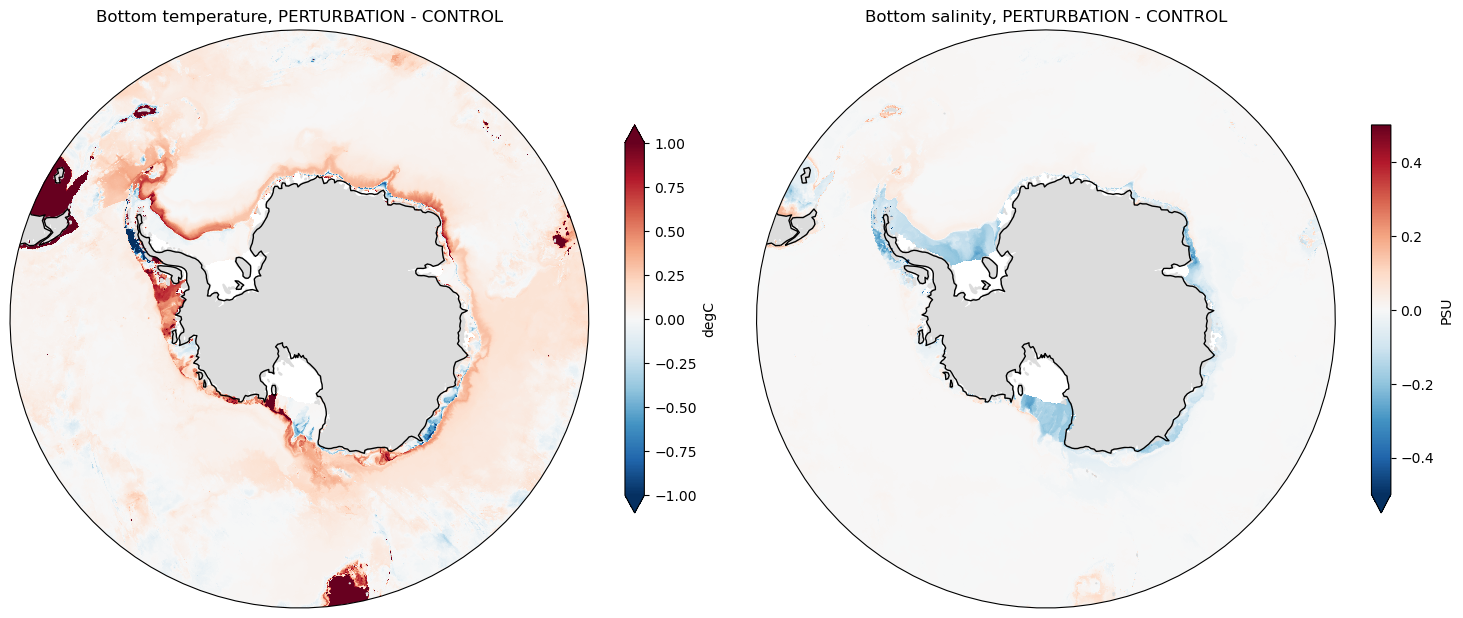

In [11]:
fig = plt.figure(figsize = (15, 10))
axs = [fig.add_subplot(121, projection = ccrs.SouthPolarStereo()),
       fig.add_subplot(122, projection = ccrs.SouthPolarStereo())]
for ax in axs:
    ax = stereographic_axis(ax)

temp_anom_b.plot(ax = axs[0], cmap = 'RdBu_r', vmin = -1, vmax = 1,
                 transform = ccrs.PlateCarree(), cbar_kwargs = {'label':'degC', 'shrink':0.4})
axs[0].set_title('Bottom temperature, PERTURBATION - CONTROL');

salt_anom_b.plot(ax = axs[1], cmap = 'RdBu_r', vmin = -.5, vmax = .5,
                 transform = ccrs.PlateCarree(), cbar_kwargs = {'label':'PSU', 'shrink':0.4})
axs[1].set_title('Bottom salinity, PERTURBATION - CONTROL');

plt.tight_layout();

Note how the largest changes so far are appearing at the continental shelf, which is where the bottom has its fastest connection with the surface via deep convection. 

The most striking response in bottom temperatures is the well-known warming in the Amundsen-Bellinghausen continental shelf, west of the Antarctic Peninsula, which is associated to Circumpolar Deep Water flooding the shelf. 

Bottom salinities show a circumpolar freshening, which is probably associated to the weakening of deep convection of dense waters over the shelf.

#### Question 3

Calculate the changes in temperature and salinity at ~500m depth, which is the depth at which Circumpolar Deep Water sits in the water column. Discuss the resulting plots.

*Answer here*

## Changes to Drake Passage transport

Let's calculate the transport streamfunction, and calculate the Drake Passage transport for the control simulation and the perturbation. Remember that this is a way to monitor changes to the Antarctic Circumpolar Current strength.

In [12]:
T_control = control['tx_trans_int_z']/(1035*1e6)
T_exp_585 = exp_585['tx_trans_int_z']/(1035*1e6)

ψ_control = T_control.cumsum('yt_ocean')
ψ_exp_585 = T_exp_585.cumsum('yt_ocean')

In [13]:
ψ_south_america = ψ_control.sel(xu_ocean = -68, yt_ocean = -55, method = 'nearest')
ψ_antarctic_pen = ψ_control.sel(xu_ocean = -62, yt_ocean = -64, method = 'nearest')
DP_transport_control = ψ_south_america - ψ_antarctic_pen

ψ_south_america = ψ_exp_585.sel(xu_ocean = -68, yt_ocean = -55, method = 'nearest')
ψ_antarctic_pen = ψ_exp_585.sel(xu_ocean = -62, yt_ocean = -64, method = 'nearest')
DP_transport_exp_585 = ψ_south_america - ψ_antarctic_pen

In [14]:
DP_transport_control.values

array(138.24509, dtype=float32)

In [15]:
DP_transport_exp_585.values

array(129.43185, dtype=float32)

The Drake Passage transport has weakened in around 10 Sv! This is a somewhat surprising result, because remember that we are forcing our model with stronger surface winds - yet somehow the strength of the Antarctic Circumpolar Current has *decreased*.

The specific reasons for this weakening are yet to be investigated. Goes to illustrate that there are still aspects we don't fully understand about the dynamics of the ACC. 

## Changes to the MOC

Let's calculate changes to the strength of the MOC. 

In [72]:
Ty_rho = control['ty_trans_rho'] / (1035*1e6)
Ty_rho_int_x = Ty_rho.sum('grid_xt_ocean')
ψ_rho_control = Ty_rho_int_x.cumsum('potrho') 

Ty_rho = exp_585['ty_trans_rho'] / (1035*1e6)
Ty_rho_int_x = Ty_rho.sum('grid_xt_ocean')
ψ_rho_exp_585 = Ty_rho_int_x.cumsum('potrho') 

In [79]:
levels =  np.hstack((np.arange(-35, 0, 4), np.flip(-np.arange(-35, 0, 4))))
cbarticks = np.hstack((np.flip(-np.arange(3, 35, 6)), np.arange(3, 35, 6)))

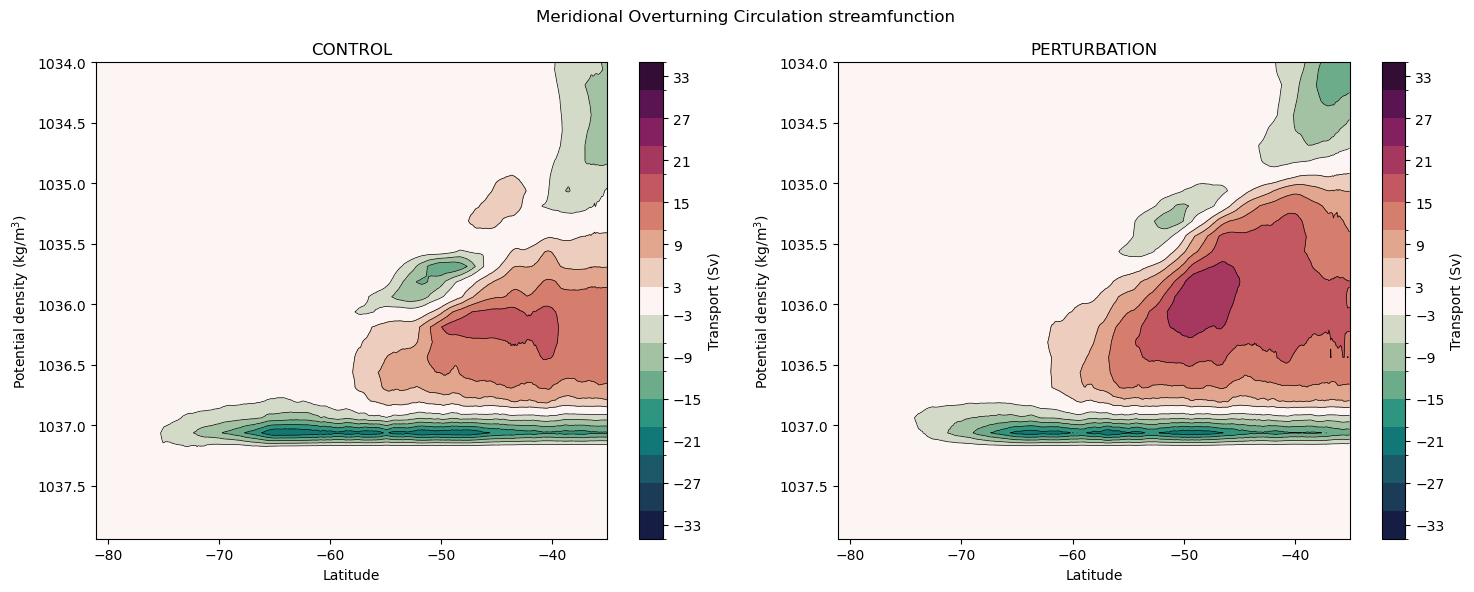

In [80]:
fig, axs = plt.subplots(1, 2, figsize = (15, 6))
ψ_rho_control.plot.contourf(ax = axs[0], levels = levels, cmap = cm.cm.curl, 
                    cbar_kwargs = {'label':'Transport (Sv)', 'ticks':cbarticks})
ψ_rho_control.plot.contour(ax = axs[0], levels = levels, colors = ['k'], linewidths = [0.5])
axs[0].set_title('CONTROL');
axs[0].set_ylabel('Potential density (kg/m$^3$)')
ψ_rho_exp_585.plot.contourf(ax = axs[1], levels = levels, cmap = cm.cm.curl, 
                    cbar_kwargs = {'label':'Transport (Sv)', 'ticks':cbarticks})
ψ_rho_exp_585.plot.contour(ax = axs[1], levels = levels, colors = ['k'], linewidths = [0.5])
axs[1].set_ylabel('Potential density (kg/m$^3$)')
axs[1].set_title('PERTURBATION')
for ax in axs:
    ax.set_xlabel('Latitude');
    ax.invert_yaxis();
    ax.set_ylim(None, 1034);
fig.suptitle('Meridional Overturning Circulation streamfunction');
plt.tight_layout();

It is hard to visualise the changes in the abyssal cell, so we can quantify them instead. We can calculate the strength of the abyssal overturning cell by selecting potential densities larger than 1036, and calculate the minimum of the stramfunction:

In [81]:
MOC_strength_control = ψ_rho_control.sel(potrho = slice(None, 1036)).min().values
MOC_strength_exp_585 = ψ_rho_exp_585.sel(potrho = slice(None, 1036)).min().values

In [82]:
MOC_strength_control

array(-14.793337, dtype=float32)

In [83]:
MOC_strength_exp_585

array(-14.738432, dtype=float32)

Barely any changes! This might be because (a) the abyssal overturning cell is not that sensitive to wind+thermal+precip changes or also (b) we are looking at the only the 10th year of simulation, and the changes take longer to reach the bottom of the ocean. 

However, look how the upwelling branch of NADW (the reds in the figure) get stronger: this is probably because this upwelling is driven by surface winds winds, and therefore strengthening the winds strengthens the upwelling. 

## Antarctic Slope Current changes

The Antarctic Slope Current (ASC) is a quasi-circumpolar current that flows around Antarctica in an anti-clockwise direction. We say it is quasi-circumpolar because it is either absent or very weak in West Antarctica. It is a really important dynamical feature of the ocean circulation, because typically when there is a strong, established current, the exchange of water masses from either side becomes inhibited - in other words, the ASC acts as a barrier for open-ocean water masses to come onto the shelf. Remember that open-ocean water masses are usually warmer than the waters on shelf, and so this mediating role controls to a certain extant how much heat gets to the ice shelves. The lack (or weakness) of the ASC in West Antarctica is one of the reasons behind the vulnerability of this area and the increased melt rates observed here. 

The ASC's properties vary around the Antarctic margins, and it is usually classified into three distinct regimes: a surface intensified, a bottom intensified, and a reverse ASC. These are illustrated in the figure below from [Huneke et al. (2022)](https://journals.ametsoc.org/view/journals/phoc/52/3/JPO-D-21-0143.1.xml):

![image](images/asc_regimes.png)

Each of these regimes is associated with a particular temperature/salinity structure of the Antarctic Slope Front - fresh ASF, dense ASF and warm ASF. You can see the spatial distribution of these three regimes in the following figure from [Thompson et al. (2018)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2018RG000624):

![image](images/asf_regimes.png)

Let's choose some locations representative of the three different ASC regimes and see what's happened to the velocity fields:

In [39]:
asc_fresh_c = control['u'].sel(xu_ocean = slice(-10, 10), yu_ocean = slice(-72, -68), st_ocean = slice(None, 1500)).mean('xu_ocean')
asc_fresh_p = exp_585['u'].sel(xu_ocean = slice(-10, 10), yu_ocean = slice(-72, -68), st_ocean = slice(None, 1500)).mean('xu_ocean')

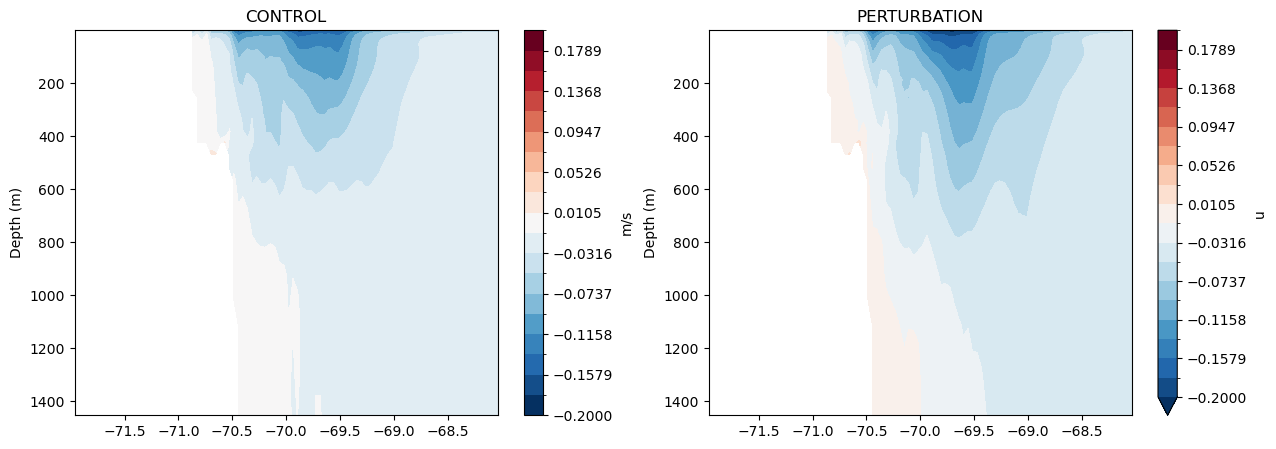

In [40]:
fig, axs = plt.subplots(1, 2, figsize = (15,5))
asc_fresh_c.plot.contourf(ax = axs[0], levels = 20, vmin = -.2, vmax = .2, cmap = 'RdBu_r',
                          cbar_kwargs = {'label':'m/s'})
asc_fresh_p.plot.contourf(ax = axs[1], levels = 20, vmin = -.2, vmax = .2, cmap = 'RdBu_r')
axs[0].set_title('CONTROL')
axs[1].set_title('PERTURBATION')
for ax in axs:
    ax.invert_yaxis();
    ax.set_ylabel('Depth (m)');
    ax.set_xlabel('');

#### Question 4

What has happened to the ASC in the perturbation simulation? Is it stronger or weaker than CONTROL?

*Answer here*

In [56]:
asc_dense_c = control['u'].sel(xu_ocean = slice(-240, -230), yu_ocean = slice(-67.5, -64), st_ocean = slice(None, 4000)).mean('xu_ocean')
asc_dense_p = exp_585['u'].sel(xu_ocean = slice(-240, -230), yu_ocean = slice(-67.5, -64), st_ocean = slice(None, 4000)).mean('xu_ocean')

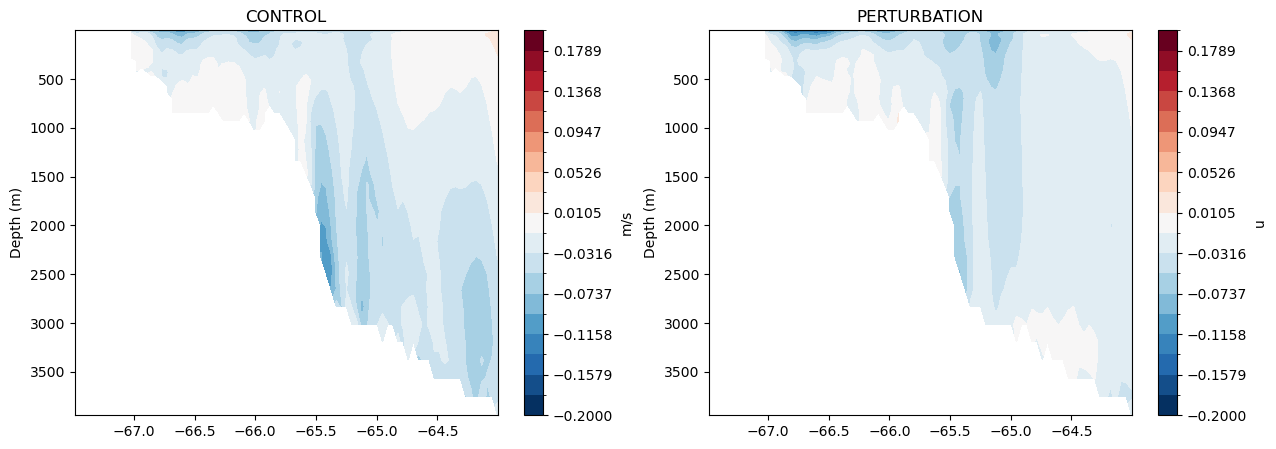

In [57]:
fig, axs = plt.subplots(1, 2, figsize = (15,5))
asc_dense_c.plot.contourf(ax = axs[0], levels = 20, vmin = -.2, vmax = .2, cmap = 'RdBu_r',
                          cbar_kwargs = {'label':'m/s'})
asc_dense_p.plot.contourf(ax = axs[1], levels = 20, vmin = -.2, vmax = .2, cmap = 'RdBu_r')
axs[0].set_title('CONTROL')
axs[1].set_title('PERTURBATION')
for ax in axs:
    ax.invert_yaxis();
    ax.set_ylabel('Depth (m)');
    ax.set_xlabel('');

#### Question 5

This one is a bit more tricky: identify the bottom-intensified ASC, and describe what has happened in the perturbation experiment.

*Answer here*

#### Question 6

Plot the same thing, but for the warm shelf regime (reversed ASC).

*Answer here*